# Module03 Final Project

The goal of this project is to develop a model to predict churn in the customer base of a telecom company. This is a binary classification problem, and the preference will be for false positives over false negatives, as the company would like to capture as many customers as possible before they leave.

I start by importing the needed modules.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFE, RFECV
import pandas.util.testing as tm

# Data Exploration

I looked at the dataframe and compared the churn vs. non-churn customers to get an overall sense of the dataset.

In [3]:
df = pd.read_csv('churn.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.groupby(['churn']).mean() 

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
churn,,,,,,,,,,,,,,,,
False,100.793684,437.074737,8.604561,175.175754,100.283158,29.780421,199.043298,100.038596,16.918909,200.133193,100.058246,9.006074,10.158877,4.532982,2.743404,1.449825
True,102.664596,437.817805,5.115942,206.914079,101.335404,35.175921,212.410145,100.561077,18.054969,205.231677,100.399586,9.235528,10.700000,4.163561,2.889545,2.229814


In [5]:
df.groupby(['churn']).describe() 

account length                                                        \
               count        mean       std  min   25%    50%    75%    max   
churn                                                                        
False         2850.0  100.793684  39.88235  1.0  73.0  100.0  127.0  243.0   
True           483.0  102.664596  39.46782  1.0  76.0  103.0  127.0  225.0   

      area code              ... total intl charge       \
          count        mean  ...               75%  max   
churn                        ...                          
False    2850.0  437.074737  ...              3.24  5.1   
True      483.0  437.817805  ...              3.46  5.4   

      customer service calls                                               
                       count      mean       std  min  25%  50%  75%  max  
churn                                                                      
False                 2850.0  1.449825  1.163883  0.0  1.0  1.0  2.0  8.0  
True                   483.0  2.229814  1.853275  0.0  1.0  2.0  4.0  9.0  

[2 rows x 128 columns]

In [6]:
df_false = df.loc[df['churn'] == False]
df_true = df.loc[df['churn'] == True]
df_true.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.00000,483.000000,483.000000,483.000000
mean,102.664596,437.817805,5.115942,206.914079,101.335404,35.175921,212.410145,100.561077,18.054969,205.231677,100.399586,9.235528,10.70000,4.163561,2.889545,2.229814
std,39.467820,42.792270,11.860138,68.997792,21.582307,11.729710,51.728910,19.724711,4.396762,47.132825,19.950659,2.121081,2.79319,2.551575,0.754152,1.853275
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,70.900000,48.000000,6.030000,47.400000,49.000000,2.130000,2.00000,1.000000,0.540000,0.000000
25%,76.000000,408.000000,0.000000,153.250000,87.500000,26.055000,177.100000,87.000000,15.055000,171.250000,85.000000,7.705000,8.80000,2.000000,2.380000,1.000000
50%,103.000000,415.000000,0.000000,217.600000,103.000000,36.990000,211.300000,101.000000,17.960000,204.800000,100.000000,9.220000,10.60000,4.000000,2.860000,2.000000
75%,127.000000,510.000000,0.000000,265.950000,116.500000,45.210000,249.450000,114.000000,21.205000,239.850000,115.000000,10.795000,12.80000,5.000000,3.460000,4.000000
max,225.000000,510.000000,48.000000,350.800000,165.000000,59.640000,363.700000,168.000000,30.910000,354.900000,158.000000,15.970000,20.00000,20.000000,5.400000,9.000000


In [7]:
df_false.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000,2850.000000
mean,100.793684,437.074737,8.604561,175.175754,100.283158,29.780421,199.043298,100.038596,16.918909,200.133193,100.058246,9.006074,10.158877,4.532982,2.743404,1.449825
std,39.882350,42.306156,13.913125,50.181655,19.801157,8.530835,50.292175,19.958414,4.274863,51.105032,19.506246,2.299768,2.784489,2.441984,0.751784,1.163883
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,142.825000,87.000000,24.282500,164.500000,87.000000,13.980000,165.900000,87.000000,7.470000,8.400000,3.000000,2.270000,1.000000
50%,100.000000,415.000000,0.000000,177.200000,100.000000,30.120000,199.600000,100.000000,16.970000,200.250000,100.000000,9.010000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,22.000000,210.300000,114.000000,35.750000,233.200000,114.000000,19.820000,234.900000,113.000000,10.570000,12.000000,6.000000,3.240000,2.000000
max,243.000000,510.000000,51.000000,315.600000,163.000000,53.650000,361.800000,170.000000,30.750000,395.000000,175.000000,17.770000,18.900000,19.000000,5.100000,8.000000


I looked to see if any columns had a high number of unique values, as those would be candidates for dropping from
the dataframe

In [8]:
# look for columns to drop
for value in df.columns:
    print(value, df[value].nunique(), len(df))

state 51 3333
account length 212 3333
area code 3 3333
phone number 3333 3333
international plan 2 3333
voice mail plan 2 3333
number vmail messages 46 3333
total day minutes 1667 3333
total day calls 119 3333
total day charge 1667 3333
total eve minutes 1611 3333
total eve calls 123 3333
total eve charge 1440 3333
total night minutes 1591 3333
total night calls 120 3333
total night charge 933 3333
total intl minutes 162 3333
total intl calls 21 3333
total intl charge 162 3333
customer service calls 10 3333
churn 2 3333


Each phone number is unique, as expected, so I'll drop that since it won't help with classifying our observations.

In [9]:
df = df.drop(columns=['phone number'])

Next, I'll look for correlation between columns. High correlation between two columns indicates one can be dropped.

In [10]:
# correlation matrix
df_copy = df.copy()
corr_matrix = df_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
account length,NaN,0.012463,0.004628,0.006216,0.038470,0.006214,0.006757,0.019260,0.006745,0.008955,0.013176,0.008960,0.009514,0.020661,0.009546,0.003796,0.016541
area code,NaN,NaN,0.001994,0.008264,0.009646,0.008264,0.003580,0.011886,0.003607,0.005825,0.016522,0.005845,0.018288,0.024179,0.018395,0.027572,0.006174
number vmail messages,NaN,NaN,NaN,0.000778,0.009548,0.000776,0.017562,0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,0.013263,0.089728
total day minutes,NaN,NaN,NaN,NaN,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,0.010155,0.008033,0.010092,0.013423,0.205151
total day calls,NaN,NaN,NaN,NaN,NaN,0.006753,0.021451,0.006462,0.021449,0.022938,0.019557,0.022927,0.021565,0.004574,0.021666,0.018942,0.018459
total day charge,NaN,NaN,NaN,NaN,NaN,NaN,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,0.010157,0.008032,0.010094,0.013427,0.205151
total eve minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011430,1.000000,0.012584,0.007586,0.012593,0.011035,0.002541,0.011067,0.012985,0.092796
total eve calls,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011423,0.002093,0.007710,0.002056,0.008703,0.017434,0.008674,0.002423,0.009233
total eve charge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012592,0.007596,0.012601,0.011043,0.002541,0.011074,0.012987,0.092786
total night minutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011204,0.999999,0.015207,0.012353,0.015180,0.009288,0.035493


The number of minutes and the charge for four categories is perfectly correlated, as would be expected, so I'll drop the four charge columns.

In [11]:
df = df.drop(columns=['total day charge', 'total eve charge', 'total night charge', 'total intl charge'])


I'll also check to see if any columns have missing values.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total night minutes     3333 non-null   float64
 11  total night calls       3333 non-null   int64  
 12  total intl minutes      3333 non-null   float64
 13  total intl calls        3333 non-null   int64  
 14  customer service calls  3333 non-null   

None do.

Next, I'll look at the distribution of each value in each column.

In [13]:
for var in df.columns:
    print(var,'\n', df[var].value_counts()/len(df))

state 
 WV    0.031803
MN    0.025203
NY    0.024902
AL    0.024002
OH    0.023402
OR    0.023402
WI    0.023402
VA    0.023102
WY    0.023102
CT    0.022202
ID    0.021902
MI    0.021902
VT    0.021902
UT    0.021602
TX    0.021602
IN    0.021302
KS    0.021002
MD    0.021002
NC    0.020402
NJ    0.020402
MT    0.020402
NV    0.019802
CO    0.019802
WA    0.019802
RI    0.019502
MS    0.019502
MA    0.019502
AZ    0.019202
MO    0.018902
FL    0.018902
NM    0.018602
ME    0.018602
ND    0.018602
DE    0.018302
OK    0.018302
NE    0.018302
SD    0.018002
SC    0.018002
KY    0.017702
IL    0.017402
NH    0.016802
AR    0.016502
DC    0.016202
GA    0.016202
HI    0.015902
TN    0.015902
AK    0.015602
LA    0.015302
PA    0.013501
IA    0.013201
CA    0.010201
Name: state, dtype: float64
account length 
 105    0.012901
87     0.012601
93     0.012001
101    0.012001
90     0.011701
         ...   
191    0.000300
199    0.000300
215    0.000300
221    0.000300
2      0.000300
Name: 

There is a class imbalance for the target, so I will have to address that.

# Data Pre-Processing

I'll divide the features in to a continuous list and a categorical list.

In [14]:
continuous = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total eve minutes', 
             'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls',
             'customer service calls']

categorical = ['state', 'area code', 'international plan', 'voice mail plan']


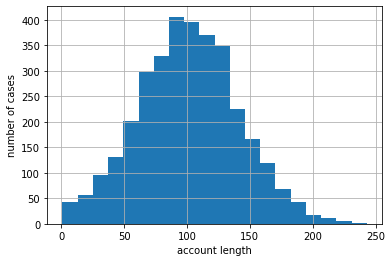

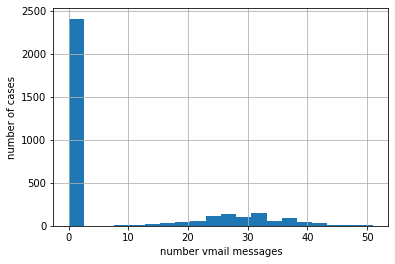

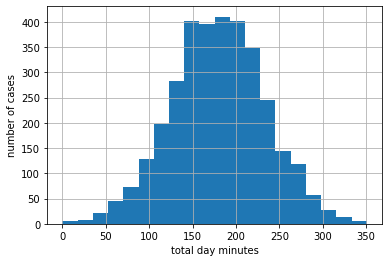

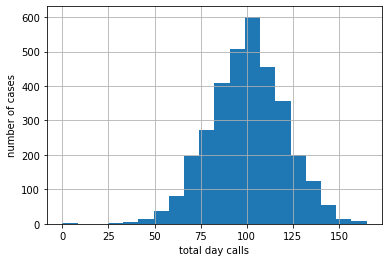

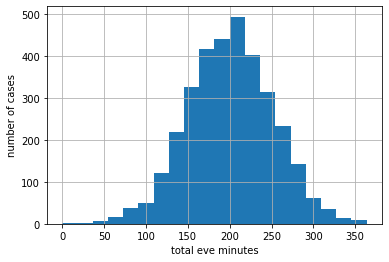

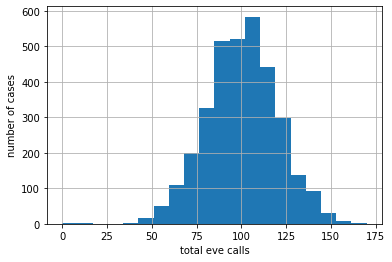

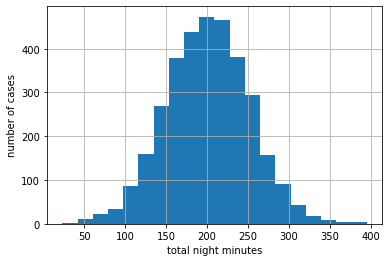

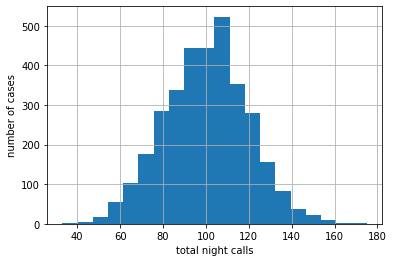

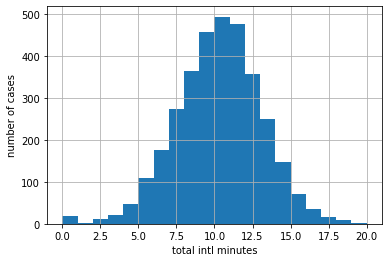

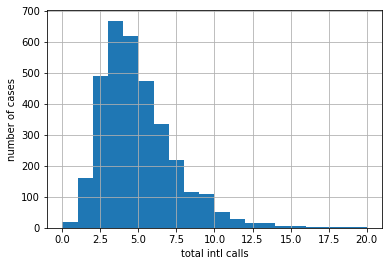

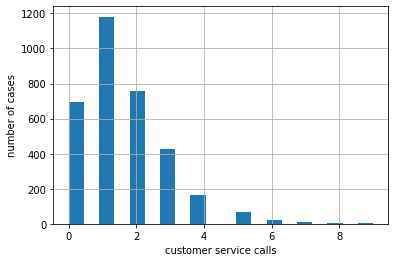

In [15]:
for feat in continuous:    
    fig = df[feat].hist(bins=20)
    fig.set_ylabel('number of cases')
    fig.set_xlabel(feat)
    
    plt.show()

In [16]:
cont_df = df.drop(columns=categorical)
cont_df=cont_df.drop(columns='churn')

scaler = StandardScaler()
cont_scaled = scaler.fit_transform(cont_df)
cont_scaled_df = pd.DataFrame(cont_scaled, columns = continuous)

cont_scaled_df['churn'] = df['churn']
cont_scaled_df.head()


,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,0.676489,1.234883,1.566767,0.476643,-0.070610,-0.055940,0.866743,-0.465494,-0.085008,-0.601195,-0.427932,False
1,0.149065,1.307948,-0.333738,1.124503,-0.108080,0.144867,1.058571,0.147825,1.240482,-0.601195,-0.427932,False
2,0.902529,-0.591760,1.168304,0.675985,-1.573383,0.496279,-0.756869,0.198935,0.703121,0.211534,-1.188218,False
3,-0.428590,-0.591760,2.196596,-1.466936,-2.742865,-0.608159,-0.078551,-0.567714,-1.303026,1.024263,0.332354,False
4,-0.654629,-0.591760,-0.240090,0.626149,-1.038932,1.098699,-0.276311,1.067803,-0.049184,-0.601195,1.092641,False


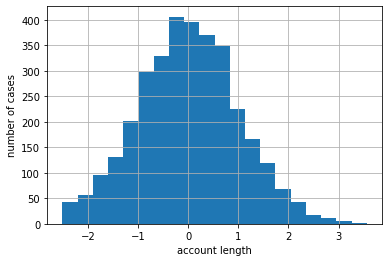

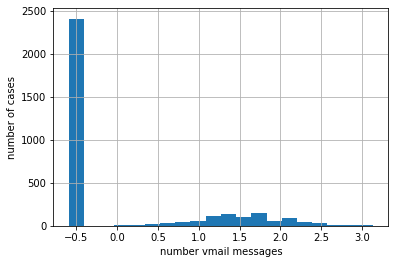

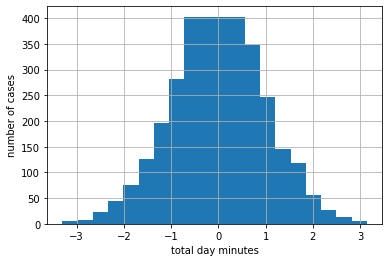

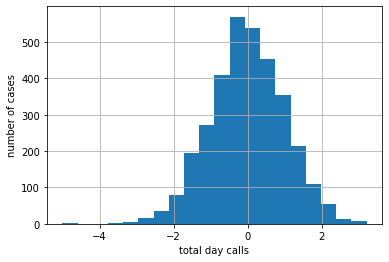

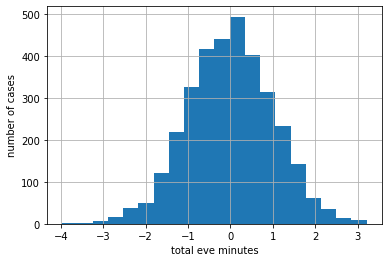

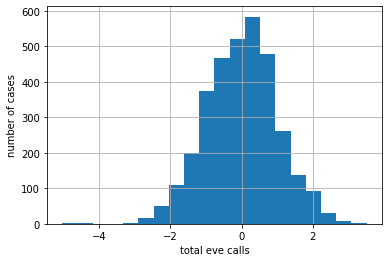

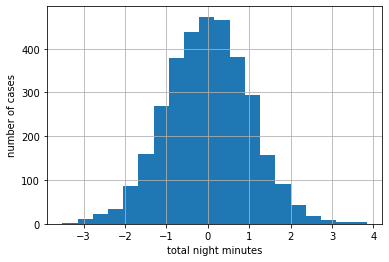

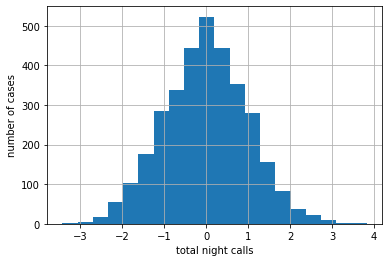

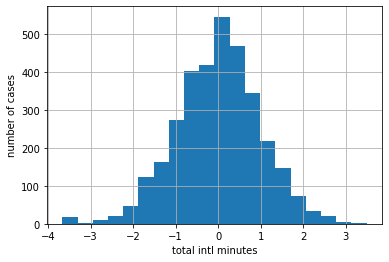

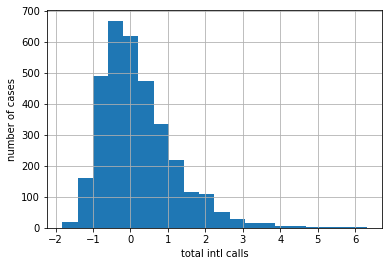

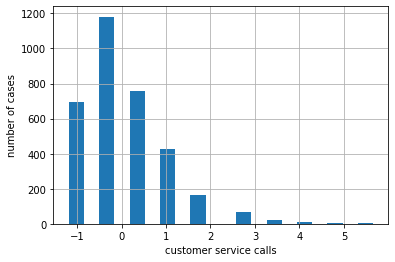

In [17]:
for feat in continuous:    
    fig = cont_scaled_df[feat].hist(bins=20)
    fig.set_ylabel('number of cases')
    fig.set_xlabel(feat)
    
    plt.show()

The skew of the columns 'total intl calls' and 'customer service calls' needs to be addressed. I did so with reciprocal transformations.

This is the skew before and after transformation of the column 'total intl calls'.

In [18]:
df_copy = cont_scaled_df.copy()
df_copy['total intl calls'].skew(skipna = True)

1.3214781658271222

In [19]:
df_copy['total intl calls_rec'] = df_copy['total intl calls'].map(lambda x: np.reciprocal(x))
print(df_copy['total intl calls_rec'].skew(skipna = True))

0.11969983285466704


This is the skew before and after transformation of the column 'customer service calls'.

In [20]:
df_copy = cont_scaled_df.copy()
df_copy['customer service calls'].skew(skipna = True)

1.0913594824728512

In [21]:
df_copy['customer service calls_rec'] = df_copy['customer service calls'].map(lambda x: np.reciprocal(x))
print(df_copy['customer service calls_rec'].skew(skipna = True))

0.4295442177523246


The skew was brought down significantly for both. I then replaced those two columns in the continuous feature dataframe.

In [22]:
cont_scaled_df['total intl calls_rec'] = cont_scaled_df['total intl calls'].map(lambda x: np.reciprocal(x))
cont_scaled_df.drop(['total intl calls'], axis=1, inplace=True)

In [36]:
cont_scaled_df['customer service calls_rec'] = cont_scaled_df['customer service calls'].map(lambda x: np.reciprocal(x))
cont_scaled_df.drop(['customer service calls'], axis=1, inplace=True)

In [37]:
cont_scaled_df.head()

,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,churn,total intl calls_rec,customer service calls_rec
0,0.676489,1.234883,1.566767,0.476643,-0.070610,-0.055940,0.866743,-0.465494,-0.085008,False,-1.663354,-2.336820
1,0.149065,1.307948,-0.333738,1.124503,-0.108080,0.144867,1.058571,0.147825,1.240482,False,-1.663354,-2.336820
2,0.902529,-0.591760,1.168304,0.675985,-1.573383,0.496279,-0.756869,0.198935,0.703121,False,4.727375,-0.841596
3,-0.428590,-0.591760,2.196596,-1.466936,-2.742865,-0.608159,-0.078551,-0.567714,-1.303026,False,0.976312,3.008836
4,-0.654629,-0.591760,-0.240090,0.626149,-1.038932,1.098699,-0.276311,1.067803,-0.049184,False,-1.663354,0.915214


I one-hot encoded the categorical columns.

In [38]:
state_dummies = pd.get_dummies(df['state'], prefix='state', drop_first=True)
area_dummies = pd.get_dummies(df['area code'], prefix='area', drop_first=True)
intl_dummies = pd.get_dummies(df['international plan'], prefix='intl', drop_first=True)
vm_dummies = pd.get_dummies(df['voice mail plan'], prefix='vm', drop_first=True)


I then put all the pre-processed features into a new dataframe.

In [39]:
df_final = pd.concat([cont_scaled_df, state_dummies, area_dummies, intl_dummies, vm_dummies], axis=1)
df_final

,account length,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,churn,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,area_415,area_510,intl_yes,vm_yes
0,0.676489,1.234883,1.566767,0.476643,-0.070610,-0.055940,0.866743,-0.465494,-0.085008,False,...,0,0,0,0,0,0,1,0,0,1
1,0.149065,1.307948,-0.333738,1.124503,-0.108080,0.144867,1.058571,0.147825,1.240482,False,...,0,0,0,0,0,0,1,0,0,1
2,0.902529,-0.591760,1.168304,0.675985,-1.573383,0.496279,-0.756869,0.198935,0.703121,False,...,0,0,0,0,0,0,1,0,0,0
3,-0.428590,-0.591760,2.196596,-1.466936,-2.742865,-0.608159,-0.078551,-0.567714,-1.303026,False,...,0,0,0,0,0,0,0,0,1,0
4,-0.654629,-0.591760,-0.240090,0.626149,-1.038932,1.098699,-0.276311,1.067803,-0.049184,False,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,2.283878,2.038605,-0.432895,-1.167924,0.286348,1.299506,1.547039,-0.874374,-0.120832,False,...,0,0,0,0,0,0,1,0,0,1
3329,-0.830437,-0.591760,0.942447,-2.164631,-0.938353,-2.264816,-0.189297,1.170023,-0.228304,False,...,0,0,0,0,1,0,1,0,0,0
3330,-1.835055,-0.591760,0.018820,0.426808,1.731930,-2.114211,-0.177431,-0.465494,1.383778,False,...,0,0,0,0,0,0,0,1,0,0
3331,2.082955,-0.591760,0.624778,0.227466,-0.816080,-0.808966,-1.219628,1.885562,-1.876211,False,...,0,0,0,0,0,0,0,1,1,0


# Imbalanced Target Distribution

I will now address the imbalance in the churn column using SMOTE.

In [40]:
df['churn'].value_counts()/len(df)

False    0.855086
True     0.144914
Name: churn, dtype: float64

Before doing that, I need to do a train test split.

In [41]:
y = df_final['churn']
X = df_final.drop(columns=['churn'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())


False    2131
True      368
Name: churn, dtype: int64


False    719
True     115
Name: churn, dtype: int64


In [42]:
# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 

# Preview synthetic sample class distribution
print(pd.Series(y_train_resampled).value_counts()) 


True     2131
False    2131
Name: churn, dtype: int64


# Model Building

I used several classifiers for comparison.

## Random Forest

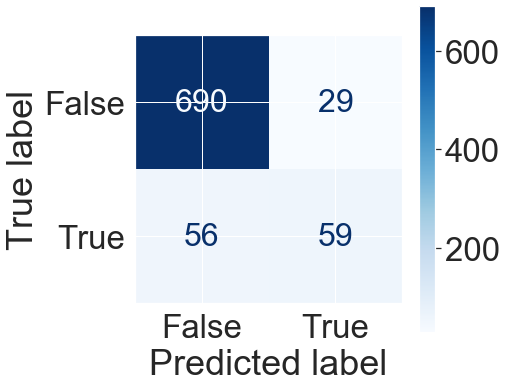

In [43]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)



I then looked at the importance of each feature to see if there were any to be dropped.

In [44]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_selector.fit(X_train_resampled, y_train_resampled)

feature_imp = pd.Series(rf_selector.feature_importances_, index=X_train_resampled.columns).sort_values(ascending=False)

feature_imp[:30]

total day minutes             0.179059
customer service calls_rec    0.131174
total eve minutes             0.069263
total intl calls_rec          0.058701
total night minutes           0.058531
total intl minutes            0.056393
account length                0.054365
total eve calls               0.052703
total night calls             0.049293
total day calls               0.048377
number vmail messages         0.036898
area_415                      0.029732
vm_yes                        0.027377
area_510                      0.025503
intl_yes                      0.023524
state_WV                      0.004191
state_VA                      0.003569
state_VT                      0.003236
state_WI                      0.002997
state_FL                      0.002793
state_NM                      0.002664
state_AL                      0.002642
state_ME                      0.002526
state_OH                      0.002523
state_NC                      0.002434
state_MN                 

Looking at the sum of all but the states, it accounts for most of the importance of the model.

In [45]:
sum(feature_imp[0:16])

0.9050829772991293

So I'll drop the states from the model.

In [46]:
df_final = pd.concat([cont_scaled_df, area_dummies, intl_dummies, vm_dummies], axis=1)
df_final

y = df_final['churn']
X = df_final.drop(columns=['churn'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train) 


              precision    recall  f1-score   support

       False       0.94      0.95      0.94       719
        True       0.65      0.62      0.63       115

    accuracy                           0.90       834
   macro avg       0.80      0.78      0.79       834
weighted avg       0.90      0.90      0.90       834



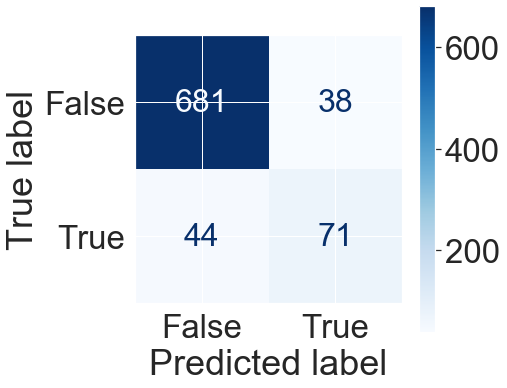

In [47]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)

print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)


That improved the model's performance. I then compared this with other classifiers.

## Logistic Regression

              precision    recall  f1-score   support

       False       0.92      0.75      0.82       719
        True       0.27      0.60      0.38       115

    accuracy                           0.73       834
   macro avg       0.60      0.67      0.60       834
weighted avg       0.83      0.73      0.76       834



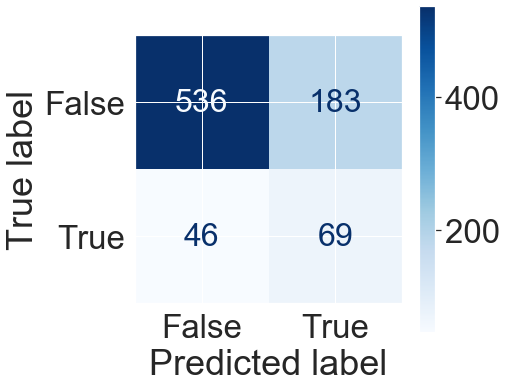

In [48]:
classifier = LogisticRegression()
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)

That did not come close to the Random Forest Classifier with an F1 of 0.37, and an accuracy of 0.71.

## GaussianNB

              precision    recall  f1-score   support

       False       0.92      0.65      0.76       719
        True       0.23      0.66      0.34       115

    accuracy                           0.65       834
   macro avg       0.58      0.65      0.55       834
weighted avg       0.83      0.65      0.70       834



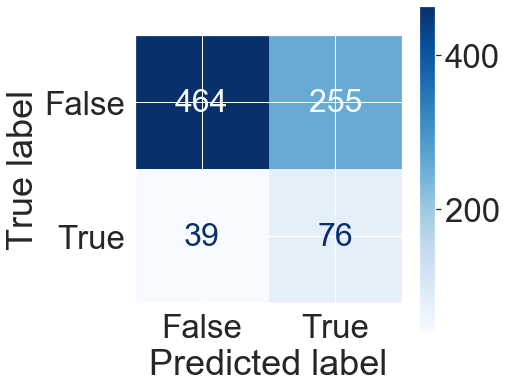

In [49]:
classifier = GaussianNB()
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)


Again, it did not outperform Random Forest Classifier with an F1 of 0.357, and an accuracy of 0.66.

## K Nearest Neighbors

I first determined the best number of neighbors before running this model.

In [64]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
    
find_best_k(X_train_resampled, y_train_resampled, X_test, y_test)


Best Value for k: 11
F1-Score: 0.40191387559808617


              precision    recall  f1-score   support

       False       0.94      0.66      0.77       719
        True       0.26      0.75      0.38       115

    accuracy                           0.67       834
   macro avg       0.60      0.70      0.58       834
weighted avg       0.85      0.67      0.72       834



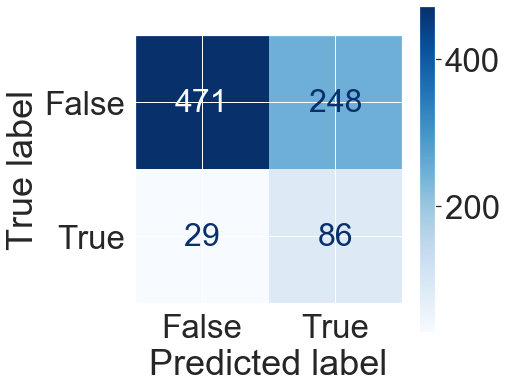

In [50]:
classifier = KNeighborsClassifier(n_neighbors=11)
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)


Better, but again not close to Random Forest Classifier with an F1 of 0.40, and an accuracy of 0.70.

## Gradient Boost

              precision    recall  f1-score   support

       False       0.97      0.90      0.93       719
        True       0.57      0.80      0.67       115

    accuracy                           0.89       834
   macro avg       0.77      0.85      0.80       834
weighted avg       0.91      0.89      0.90       834



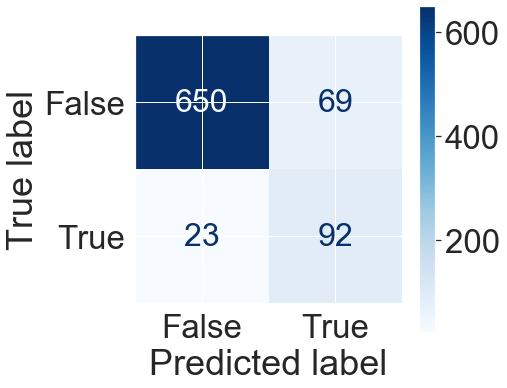

In [51]:
classifier = GradientBoostingClassifier()
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)


This model's performance is much closer to the Random Forest Classifier with an F1 of 0.63, and an accuracy of 0.88.

## XGBoost


              precision    recall  f1-score   support

       False       0.96      0.91      0.93       719
        True       0.56      0.77      0.65       115

    accuracy                           0.89       834
   macro avg       0.76      0.84      0.79       834
weighted avg       0.91      0.89      0.89       834



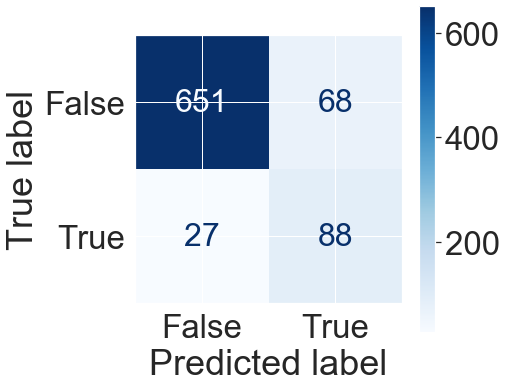

In [52]:
import xgboost as xgb

classifier = xgb.XGBClassifier()
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)


This model is comparable to the Random Forest Classifier with an F1 of 0.63, and an accuracy of 0.88.

In [53]:
training_preds = classifier.predict(X_train)

training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, y_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 92.88%
Validation accuracy: 88.61%


I then tuned the hyperparameters to see if I could improve its performance. I ran variations of the code below, optimizing for one parameter at a time, settling on the parameters below.

In [54]:
param_grid = {
    "learning_rate": [0.2],
    'max_depth': [9],
    'min_child_weight': [5],
    'subsample': [ 0.5, 0.7, 0.9],
    'n_estimators': [250],
}

grid_clf = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 9
min_child_weight: 5
n_estimators: 250
subsample: 0.9

Training Accuracy: 100.0%
Validation accuracy: 92.69%


The optimized version of the XGBoost classifier model is below.

              precision    recall  f1-score   support

       False       0.96      0.95      0.96       719
        True       0.72      0.77      0.74       115

    accuracy                           0.93       834
   macro avg       0.84      0.86      0.85       834
weighted avg       0.93      0.93      0.93       834



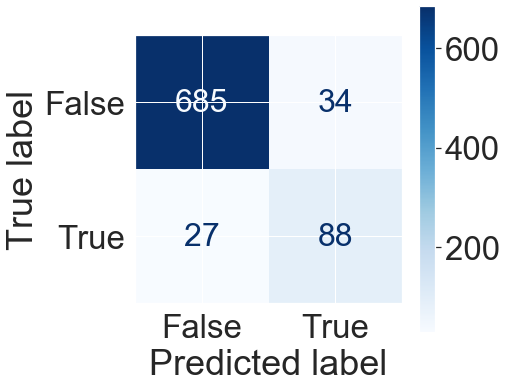

In [55]:
classifier = xgb.XGBClassifier(learning_rate= 0.2,
    max_depth= 9,
    min_child_weight= 5,
    subsample=0.9,
    n_estimators=250)
classifier.fit(X_train_resampled, y_train_resampled)
y_preds = classifier.predict(X_test)
report = classification_report(y_test, y_preds)
print(report)

fig, ax = plt.subplots(figsize=(6,6))
plt.rcParams.update({'font.size': 32})
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Blues,
                             ax=ax)


This improved the model's F1 score to 0.75, and its accuracy to 0.93.

The recall score is higher than precision, and that is good for this model, since the preference is to catch as many customers before the company loses them. False positives are preferable to false negatives.